In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mangaldipdhua","key":"bab83510f1c8209be180b5ec6e014264"}'}

In [5]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset -p /content/drive/MyDrive/PlantDiseases/

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.69G/2.70G [00:34<00:00, 103MB/s] 
100% 2.70G/2.70G [00:34<00:00, 84.0MB/s]


In [9]:
!ls /content/drive/MyDrive/PlantDiseases/

'new plant diseases dataset(augmented)'   new-plant-diseases-dataset.zip
'New Plant Diseases Dataset(Augmented)'   test


In [8]:
!unzip /content/drive/MyDrive/PlantDiseases/new-plant-diseases-dataset.zip -d /content/drive/MyDrive/PlantDiseases/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/PlantDiseases/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: /content/drive/MyDrive/PlantDiseases/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: /content/drive/MyDrive/PlantDiseases/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: /content/drive/MyDrive/PlantDiseases/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: /content/drive/MyDrive/PlantDiseases/new plant diseases dataset(augmented

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_dir = '/content/drive/MyDrive/PlantDiseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'


os.listdir(base_dir)

['train', 'valid']

#New Plant Diseases Dataset (Owner - Samir Bhattarai)
#About Dataset
This dataset is recreated using offline augmentation from the original dataset. The original dataset can be found on this github repo. This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes. The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structure. A new directory containing 33 test images is created later for prediction purpose.

Link : https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/data

#Checking the number of images in each class

In [11]:

class_counts = {}
for split in ['train', 'valid']:
    split_dir = os.path.join(base_dir, split)
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            if class_name not in class_counts:
                class_counts[class_name] = 0
            class_counts[class_name] += len(os.listdir(class_path))


#Visualizing Class Distribution

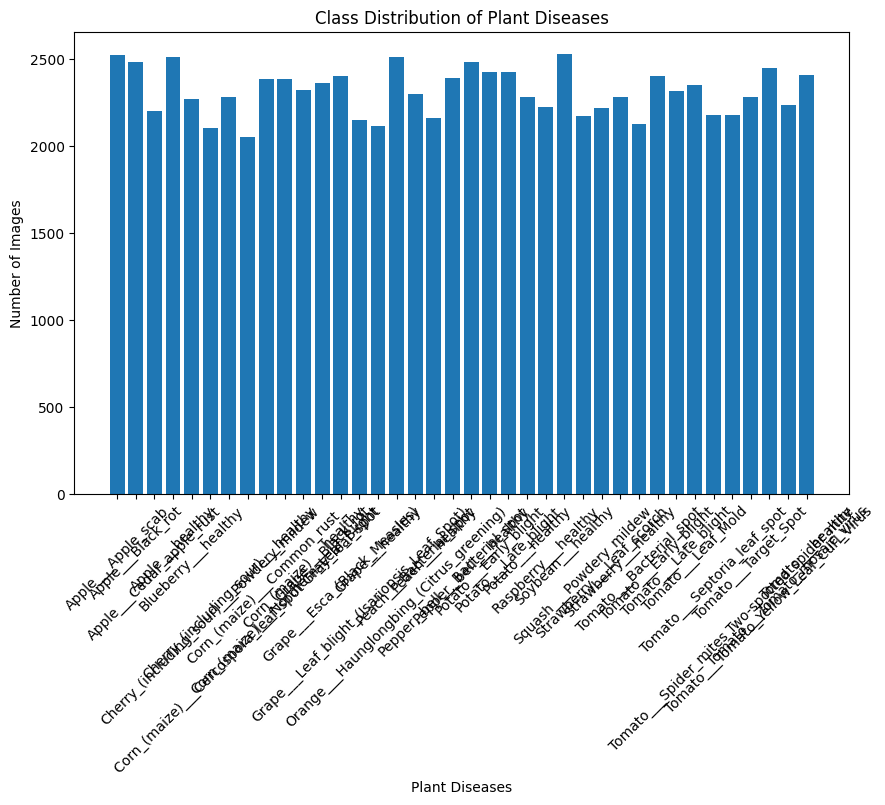

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution of Plant Diseases')
plt.xlabel('Plant Diseases')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


#Checking for Missing or Corrupted Images

In [13]:
def check_images(directory):
    for split in ['train', 'valid']:
        split_dir = os.path.join(directory, split)
        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        img = plt.imread(img_path)
                    except Exception as e:
                        print(f'Error with image {img_path}: {e}')

check_images(base_dir)


#Data Cleaning

In [14]:
def delete_corrupted_images(directory):
    for split in ['train', 'valid']:
        split_dir = os.path.join(directory, split)
        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        img = plt.imread(img_path)
                    except Exception:
                        print(f'Deleting corrupted image: {img_path}')
                        os.remove(img_path)


delete_corrupted_images(base_dir)

#Resizing Images

In [15]:
def resize_images(directory, target_size=(150, 150)):
    for split in ['train', 'valid']:
        split_dir = os.path.join(directory, split)
        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        img = Image.open(img_path)
                        img = img.resize(target_size)
                        img.save(img_path)
                    except Exception as e:
                        print(f'Error resizing image {img_path}: {e}')


resize_images(base_dir)


#Preparing Data for Training

In [16]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')


train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255.0)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


#CNN Model Building

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_counts), activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,833,254 (18.44 MB)

 Trainable params: 4,833,254 (18.44 MB)

 Non-trainable params: 0 (0.00 B)

#Model Training

In [ ]:

epochs = 20
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size


history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5368s 2s/step - accuracy: 0.2133 - loss: 2.8261 - val_accuracy: 0.6948 - val_loss: 1.0098
Epoch 2/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 2s 187us/step - accuracy: 0.5000 - loss: 1.6761 - val_accuracy: 0.7500 - val_loss: 1.1428
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


 419/2196 ━━━━━━━━━━━━━━━━━━━━ 1:02:02 2s/step - accuracy: 0.5321 - loss: 1.5175

#Visualizing Training Results

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


#Evaluating the Model

In [ ]:

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


#Saving the Model

In [ ]:

model.save('/content/drive/MyDrive/PlantDiseases/Plant_Disease_Detection_Model.h5')


#Making Predictions on New Images

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_disease(img_path):
    img = load_and_preprocess_image(img_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

# Example usage
# img_path = '/path/to/your/image.jpg'
# predicted_class = predict_disease(img_path)
# print(f'Predicted class: {predicted_class}')
